## AutoEncoder Experiments with MNIST
Followings are the contents of this project:

A. Data Loading and Plotting

B. AutoEncoder Graph Construction
    1. Define the input output tensors
    2. Define the graph and construct it
    3. Define loss and optimizer

C. Run Session

D. Show some reconstructed images

E. Plot Embeddings

F. Do Image Generation by Decoder

In [1]:
import gzip
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
# Shuffle arrays or sparse matrices in a consistent way
from sklearn.utils import shuffle

outModelDir = './autoEncoder-shared-models-with-l2norm-on-embedding/'

## A. Data Loading and Plotting

In [3]:
dataPath='../dataset/MNIST_data/'
mnist = input_data.read_data_sets(dataPath, one_hot=True)

Extracting ../dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../dataset/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# read the images
images = mnist.train.images
images = images - 0.5 # Normalize
img_num, img_dim = images.shape
print('Images with shape {}'.format(images.shape))

Images with shape (55000, 784)


In [5]:
# read the labels
labels1Hot = mnist.train.labels
print('labels1Hot.shape = {}'.format(labels1Hot.shape))
labels = np.argmax(labels1Hot,axis=1)
labels = labels[...,np.newaxis]
print('labels.shape = {}'.format(labels.shape))
n_classes = len(np.unique(labels))

labels1Hot.shape = (55000, 10)
labels.shape = (55000, 1)


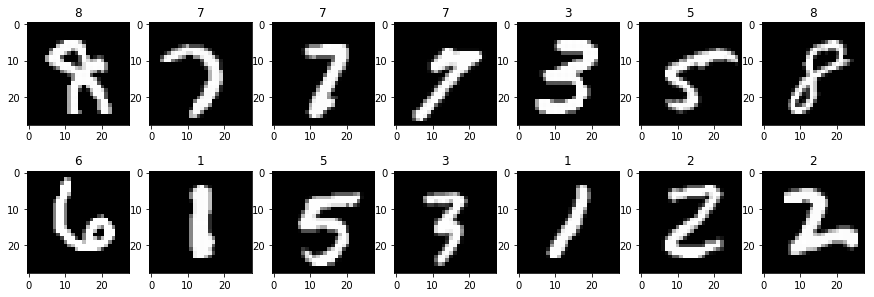

In [6]:
plt.figure(figsize=(15,5))
for i in np.arange(2*7):
    random_idx = np.random.randint(0,img_num)
    plt.subplot(2,7,i+1)
    plt.imshow(np.reshape(images[random_idx]+0.5,(28,28)),cmap='gray')
    plt.title(labels[random_idx][0])

## B. AutoEncoder Graph Construction

1. Define the input output tensors
2. Define the graph and construct it
3. Define the loss and optimizer

#### First define the hyper-parameters

In [7]:
# Hyper-parameters
EPOCHS = 100
BATCH_SIZE = 128
rate = 0.001
l2_weight = 0.1

### 1. Define the input output tensors

In [8]:
x = tf.placeholder(tf.float32, (None, img_dim))
y = tf.placeholder(tf.float32, (None, img_dim))
embedding_dim = 2
code = tf.placeholder(tf.float32, (None, embedding_dim))

### 2. Define the graph and construct it

#### First, we define all the variables

In [9]:
mu = 0
sigma = 0.1
layer_dim = {
    'layer1': 128,
    'layer2': 32,
    'embedded': embedding_dim,
    'reconstruct': img_dim
}
with tf.variable_scope('AutoEncoder') as AEScope:
    layer1_w = tf.get_variable('layer1_w',shape=(img_dim,layer_dim['layer1']),\
                                initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma))
    layer1_b = tf.get_variable('layer1_b',shape=(layer_dim['layer1']),\
                                initializer=tf.zeros_initializer())
    layer2_w = tf.get_variable('layer2_w',shape=(layer_dim['layer1'],layer_dim['layer2']),\
                                initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma))
    layer2_b = tf.get_variable('layer2_b',shape=(layer_dim['layer2']),\
                                initializer=tf.zeros_initializer())
    embedded_w = tf.get_variable('embedded_w',shape=(layer_dim['layer2'],layer_dim['embedded']),\
                                initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma))
    embedded_b = tf.get_variable('embedded_b',shape=(layer_dim['embedded']),\
                                initializer=tf.zeros_initializer())
    reconstruct_b = tf.get_variable('reconstruct_b',shape=(layer_dim['reconstruct']),\
                                initializer=tf.zeros_initializer())
    
weights = {
    'layer1': layer1_w,
    'layer2': layer2_w,
    'embedded': embedded_w
}

biases = {
    'layer1': layer1_b,
    'layer2': layer2_b,
    'embedded': embedded_b,
    'reconstruct': reconstruct_b
}
    

In [10]:
all_collection = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=AEScope.name)
print('All collection ({}) having {} variables'.format(AEScope.name,len(all_collection)))

All collection (AutoEncoder) having 7 variables


#### Then we define the graph

In [11]:
def Encoder(x):
    # Layer 1 encode: Input = batch_num x img_dim. Output = batch_num x layer_dim['layer1'].
    layer1_en   = tf.matmul(x,weights['layer1']) + biases['layer1']
    print('layer1_en has shape=',layer1_en.shape)
    # Activation.
    layer1_en = tf.nn.relu(layer1_en)

    # Layer 2 encode: Input = batch_num x layer_dim['layer1']. Output = batch_num x layer_dim['layer2'].
    layer2_en   = tf.matmul(layer1_en,weights['layer2']) + biases['layer2']
    print('layer2_en has shape=',layer2_en.shape)
    # Activation.
    layer2_en = tf.nn.relu(layer2_en)

    # Layer embedded: Input = batch_num x layer_dim['layer2']. Output = batch_num x layer_dim['embedded'].
    embedded   = tf.matmul(layer2_en,weights['embedded']) + biases['embedded']
    print('embedded has shape=',embedded.shape)
    
    return embedded


def Decoder(embedded):
    # Layer 1 decode: Input = batch_num x layer_dim['embedded']. Output = batch_num x layer_dim['layer2'].
    embedded_t = tf.matmul(embedded,weights['embedded'],transpose_b=True) + biases['layer2']
    print('embedded_t has shape=',embedded_t.shape)
    # Activation.
    embedded_t = tf.nn.relu(embedded_t)

    # Layer 2 decode: Input = batch_num x layer_dim['layer2']. Output = batch_num x layer_dim['layer1'].
    layer2_t = tf.matmul(embedded_t,weights['layer2'],transpose_b=True) + biases['layer1']
    print('layer2_t has shape=',layer2_t.shape)
    # Activation.
    layer2_t = tf.nn.relu(layer2_t)
    
    # Layer reconstruct: Input = batch_num x layer_dim['layer1']. Output = batch_num x img_dim.
    reconstruct   = tf.matmul(layer2_t,weights['layer1'],transpose_b=True) + biases['reconstruct']
    print('reconstruct has shape=',reconstruct.shape)
    # Activation.
    
    return reconstruct


In [12]:
embedded = Encoder(x)
reconstruct = Decoder(code)

layer1_en has shape= (?, 128)
layer2_en has shape= (?, 32)
embedded has shape= (?, 2)
embedded_t has shape= (?, 32)
layer2_t has shape= (?, 128)
reconstruct has shape= (?, 784)


In [13]:
def AutoEncoder(x):    
    embedded = Encoder(x)
    reconstruct = Decoder(embedded)
    
    return [embedded, reconstruct]

[embedded_auto, reconstruct_auto] = AutoEncoder(x)

layer1_en has shape= (?, 128)
layer2_en has shape= (?, 32)
embedded has shape= (?, 2)
embedded_t has shape= (?, 32)
layer2_t has shape= (?, 128)
reconstruct has shape= (?, 784)


In [14]:
all_collection = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
print('All collection ({}) having {} variables'.format(AEScope.name,len(all_collection)))

All collection (AutoEncoder) having 7 variables


### 3. Define loss and optimizer

In [15]:
# Define loss, optimizer
loss_op = tf.reduce_sum(tf.pow(tf.subtract(reconstruct_auto, y), 2.0)) + l2_weight* tf.reduce_sum(tf.pow(embedded_auto, 2.0))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_op = optimizer.minimize(loss_op)

## C. Run Session

In [ ]:
### Train your model here.
# mini-batch Adam training, will save model
if not os.path.isdir(outModelDir):
    os.makedirs(outModelDir)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = img_num
    
    print("Training...")
    print()
    train_loss = np.zeros(EPOCHS)
    for i in range(EPOCHS):
        acc_train_loss = 0
        images_train, labels_train = shuffle(images, labels1Hot)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_img, batch_label = images_train[offset:end], labels_train[offset:end]
            _, l, recon = sess.run([training_op, loss_op, reconstruct_auto], feed_dict={x: batch_img, y: batch_img})
            acc_train_loss += l/BATCH_SIZE
        train_loss[i] = acc_train_loss/len(range(0, num_examples, BATCH_SIZE))
        print("EPOCH {} ...".format(i+1))
        print("Train loss = {:.3f}".format(train_loss[i]))
        print()
    saver.save(sess, outModelDir+'mnist-fc-autoEncoder-model')
    print("Model saved")

Training...

EPOCH 1 ...
Train loss = 52.761

EPOCH 2 ...
Train loss = 41.153

EPOCH 3 ...
Train loss = 39.263

EPOCH 4 ...
Train loss = 38.194

EPOCH 5 ...
Train loss = 37.439

EPOCH 6 ...
Train loss = 36.819

EPOCH 7 ...
Train loss = 36.520

EPOCH 8 ...
Train loss = 36.169

EPOCH 9 ...
Train loss = 35.801

EPOCH 10 ...
Train loss = 35.585

EPOCH 11 ...
Train loss = 35.339

EPOCH 12 ...
Train loss = 35.148

EPOCH 13 ...
Train loss = 34.948

EPOCH 14 ...
Train loss = 34.829

EPOCH 15 ...
Train loss = 34.657

EPOCH 16 ...
Train loss = 34.517

EPOCH 17 ...
Train loss = 34.307

EPOCH 18 ...
Train loss = 34.242

EPOCH 19 ...
Train loss = 34.072

EPOCH 20 ...
Train loss = 33.977

EPOCH 21 ...
Train loss = 33.895

EPOCH 22 ...
Train loss = 33.724

EPOCH 23 ...
Train loss = 33.643

EPOCH 24 ...
Train loss = 33.522

EPOCH 25 ...
Train loss = 33.475

EPOCH 26 ...
Train loss = 33.373

EPOCH 27 ...
Train loss = 33.286

EPOCH 28 ...
Train loss = 33.192

EPOCH 29 ...
Train loss = 33.124

EPOCH 30 .

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(EPOCHS), train_loss, 'b-^')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.axis('tight')
plt.grid()

## D. Show some reconstructed images

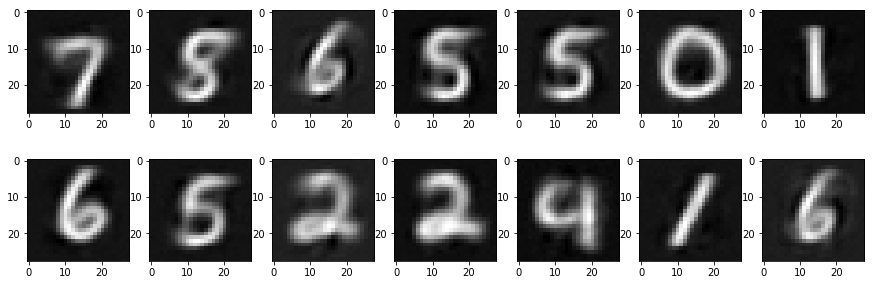

In [17]:
plt.figure(figsize=(15,5))
recon += 0.5
for i in np.arange(2*7):
    random_idx = np.random.randint(0,len(recon))
    plt.subplot(2,7,i+1)
    plt.imshow(np.reshape(recon[random_idx],(28,28)),cmap='gray')

## E. Plot Embeddings

In [18]:
#images, labels
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(outModelDir))
    embeddings = sess.run(embedded, feed_dict={x: images})
    
print('output embeddings.shape = {}'.format(embeddings.shape))

INFO:tensorflow:Restoring parameters from ./autoEncoder-shared-models-with-l2norm-on-embedding/mnist-fc-autoEncoder-model
output embeddings.shape = (55000, 2)


In [19]:
# dot colors
cmap=list()
for i in np.arange(n_classes):
    cmap.append(np.random.rand(1,3))
print(cmap[0])
permute_idx = np.random.permutation(n_classes)
cmap = [cmap[i] for i in permute_idx]

[[ 0.39005926  0.21483773  0.01554874]]


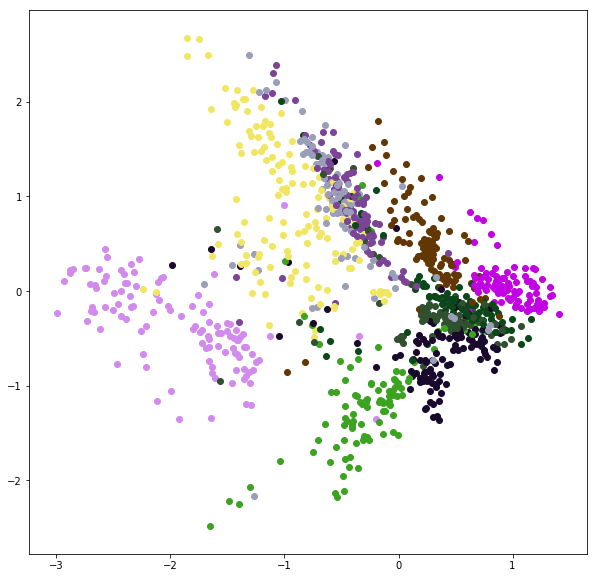

In [20]:
pylab.figure(figsize=(10,10))
for i in np.arange(0,img_num,50):
    x, y = (embeddings[i,0],embeddings[i,1])
    pylab.scatter(x,y,c=cmap[labels[i,0]])
    #pylab.scatter(x,y,c=[[1,1,1]])
    #pylab.annotate(str(labels[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

## F. Do Image Generation by Decoder

In [21]:
codes = list()
for xdim in np.arange(-1,1,0.2):
    for ydim in np.arange(-1,1,0.2):
        codes.append([xdim,ydim])
print(len(codes))

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(outModelDir))
    sampled_img = sess.run(reconstruct,feed_dict={code:codes})

100
INFO:tensorflow:Restoring parameters from ./autoEncoder-shared-models-with-l2norm-on-embedding/mnist-fc-autoEncoder-model


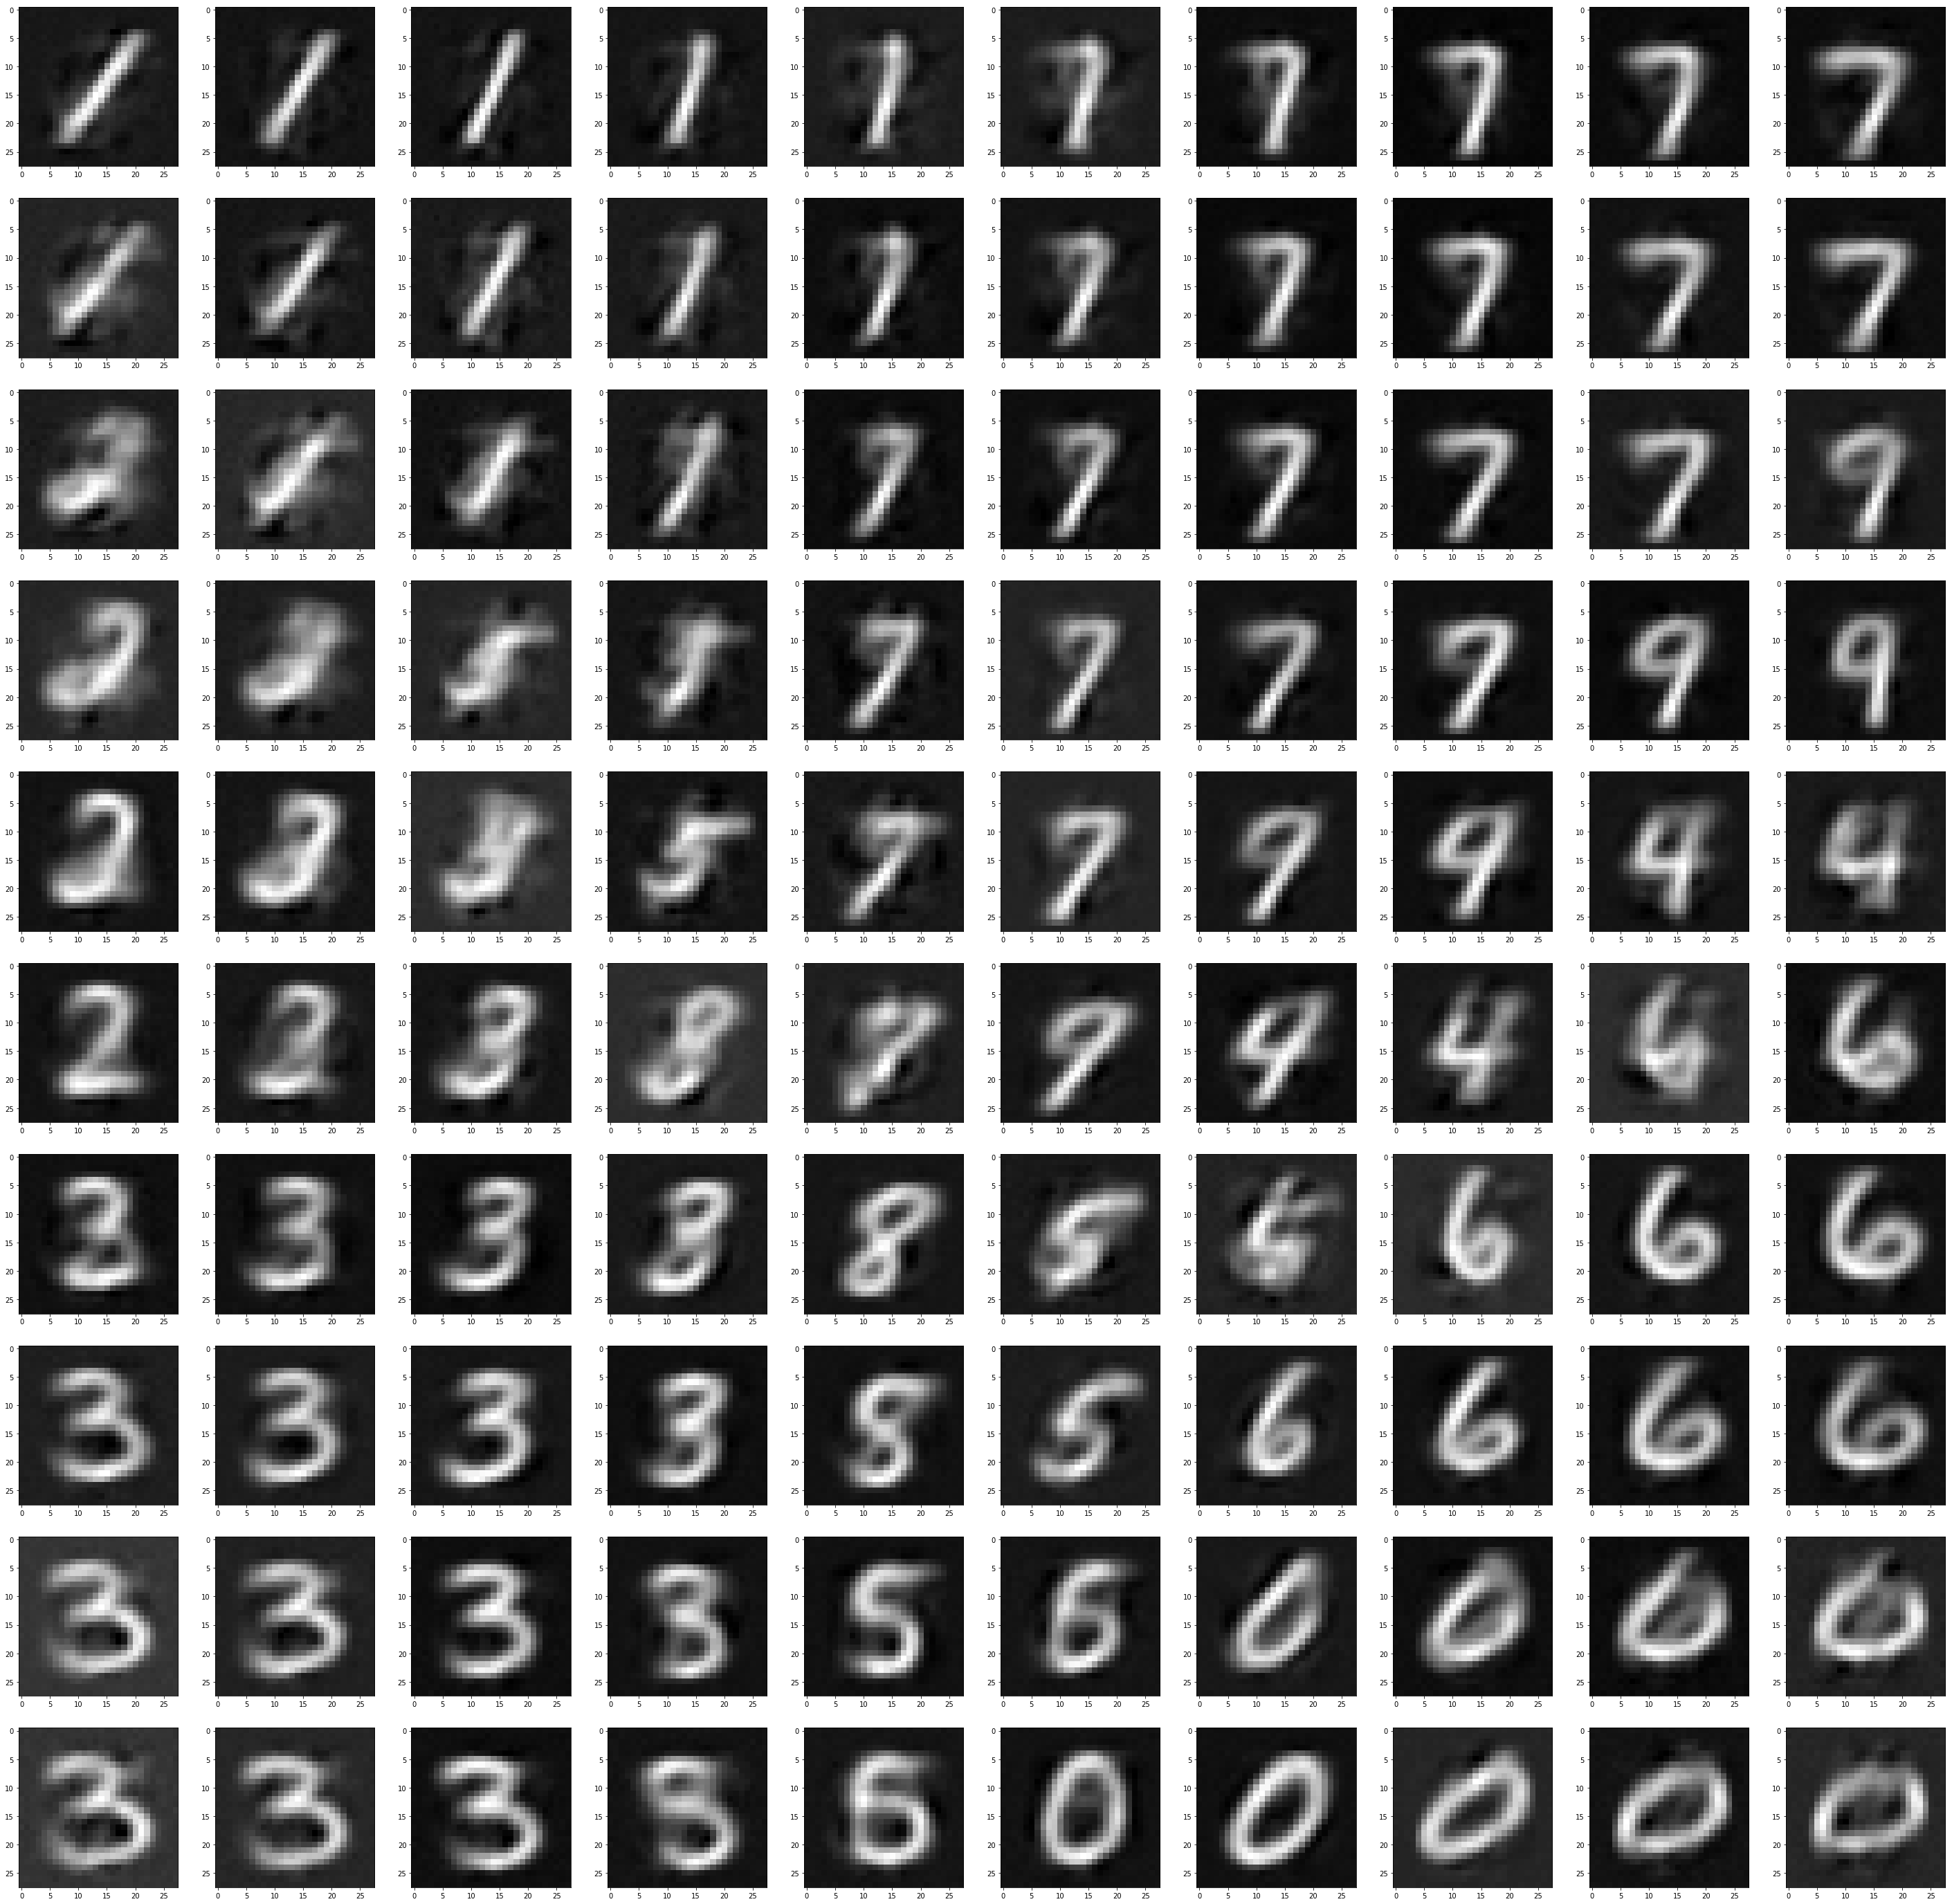

In [22]:
sampled_img.shape
plt.figure(figsize=(50,50))
sampled_img += 0.5
for i in np.arange(100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(sampled_img[i],(28,28)),cmap='gray')